In [1]:
import cv2
import gfootball.env as football_env
import  gymnasium as gym
import numpy as np

import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor

from collections import deque

In [2]:
class FootballGym(gym.Env):
    spec = None
    metadata = {'render.modes': ['human', 'rgb_array']}
    
    def __init__(self, config=None, frame_skip=1):
        super(FootballGym, self).__init__()
        env_name = '11_vs_11_easy_stochastic'
        rewards = "scoring"

        if config is not None:
            env_name = config.get("env_name", env_name)
            rewards = config.get("rewards", rewards)

        self.env = football_env.create_environment(
            env_name=env_name,
            stacked=False,
            representation="pixels",
            rewards=rewards,
            write_goal_dumps=False,
            write_full_episode_dumps=False,
            render=True,
            write_video=False,
            dump_frequency=1,
            logdir=".",
            extra_players=None,
            number_of_left_players_agent_controls=1,
            number_of_right_players_agent_controls=0,
            channel_dimensions=[224, 224 , 3])
        
        self.action_space = gym.spaces.discrete.Discrete(19)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(6, 224, 224), dtype=np.uint8)

        self.frame_skip = frame_skip
        self.reward_range = (-1, 1)
        self.n_step = 0

    def reset(self, seed=None):
        obs = self.env.reset()
        self.n_step = 0
        obs = np.moveaxis(obs, -1, 0)

        return self._get_stacked_obs(obs), {}
    
    def step(self, action):
        self.n_step += self.frame_skip

        total_reward = 0
        for _ in range(self.frame_skip):
            # Vykonaj akciu na preskočenie frameov a pridaj reward
            obs, reward, done, info = self.env.step([action])
            total_reward += reward

            if done:
                break

        obs = np.moveaxis(obs, -1, 0)

        if self.n_step >= 1500:
            done = True  # Ukončíme epizódu, keď skončí prvý polčas

        terminated = done
        truncated = False  # Ak vaše prostredie nemá časové limity, nastavte na False
        
        return self._get_stacked_obs(obs), float(total_reward), terminated, truncated, info

    
    def render(self, mode='rgb_array'):
        print("BEziiim")
        return self.env.render(mode)
    
    def _get_stacked_obs(self, obs):

        # Rozdelenie posledného frame na R, G, B kanály
        r_last = obs[9]
        g_last = obs[10]
        b_last = obs[11]

        # Konštantná šedá hodnota (napr. 128 pre strednú šedú)
        gray_base = 128

        grayscale_diffs = []

        # Pridáme posledný frame do rozdielov (bude to posledný 3 kanál)
        grayscale_diffs.append(r_last[..., np.newaxis])  # R kanál
        grayscale_diffs.append(g_last[..., np.newaxis])  # G kanál
        grayscale_diffs.append(b_last[..., np.newaxis])  # B kanál
        
        # Predchádzajúce snímky a ich rozdiely
        compare_frame = np.stack((r_last, g_last, b_last), axis=-1)
        #compare_frame = np.dot(compare_frame[...,:3], [0.2989, 0.5870, 0.1140])
        compare_frame = cv2.cvtColor(compare_frame, cv2.COLOR_RGB2GRAY)

        for i in range(6, -1, -3):
            frame = np.stack((obs[i], obs[i+1], obs[i+2]), axis=-1)
            # grayscale
            frame  = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

            diff = compare_frame.astype(np.int16) - frame.astype(np.int16)
            diff = np.clip(diff + gray_base, 0, 255).astype(np.uint8)  # Uisti sa, že hodnoty sú v rozsahu 0-255

            # Pridaj rozdiel do grayscale kanálu
            grayscale_diffs.append(diff[..., np.newaxis])  # Pridaj novú dimenziu pre channel

            compare_frame = frame

        # Stack všetky rozdielové frames a posledný frame do jedného pozorovania
        stacked_obs = np.concatenate(grayscale_diffs, axis=-1)
        stacked_obs = np.transpose(stacked_obs, (2, 0, 1))
        
        return stacked_obs




# Funkcia na vytvorenie jednotlivého prostredia
def make_football_env(rank):
    def _init():
        env = Monitor(FootballGym())

        return env
    return _init

In [3]:

env = make_football_env(0)()



In [4]:
obs, _= env.reset()

for i in range(20):
    obs, _, _, _, _ = env.step(1)

IndexError: index 9 is out of bounds for axis 0 with size 3

In [ ]:
obs.shape

(3, 224, 224)

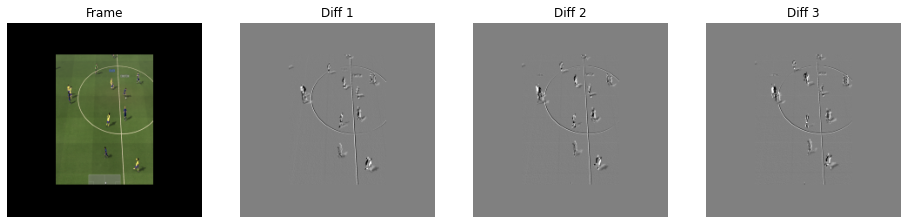

In [ ]:

# Zobrazenie jednotlivých RGB snímok
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 riadok s 4 obrázkami
axes = axes.ravel()  # Získame zoznam axov pre každý obrázok


#r = obs[i*3]  # Prvý kanál (R)
#g = obs[i*3+1]  # Druhý kanál (G)
#b = obs[i*3+2]  # Tretí kanál (B)

    # Skladajme ich do RGB obrázkov
#rgb_image = np.stack([r, g, b], axis=-1)  # Tvar (448, 448, 3)

obs = np.transpose(obs, (1, 2, 0))

axes[0].imshow(obs[..., :3])
axes[0].set_title("Frame")
axes[0].axis('off')  # Skryjeme osi

axes[1].imshow(obs[..., 3], cmap='gray')
axes[1].set_title("Diff 1")
axes[1].axis('off')  # Skryjeme osi

axes[2].imshow(obs[..., 4], cmap='gray')
axes[2].set_title("Diff 2")
axes[2].axis('off')  # Skryjeme osi

axes[3].imshow(obs[..., 5], cmap='gray')
axes[3].set_title("Diff 3")
axes[3].axis('off')  # Skryjeme osi

for ax in axes:
    ax.set_aspect('equal')


plt.show()


In [ ]:
frame = np.load("../.scratch/porovnanie/video_frame.npy")
print(frame.shape)

# Zobrazenie jednotlivých RGB snímok
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 riadok s 4 obrázkami
axes = axes.ravel()  # Získame zoznam axov pre každý obrázok

obs = np.squeeze(frame)
obs = np.transpose(obs, (1, 2, 0))

axes[0].imshow(obs[..., :3])
axes[0].set_title("Frame")
axes[0].axis('off')  # Skryjeme osi

axes[1].imshow(obs[..., 3], cmap='gray')
axes[1].set_title("Diff 1")
axes[1].axis('off')  # Skryjeme osi

axes[2].imshow(obs[..., 4], cmap='gray')
axes[2].set_title("Diff 2")
axes[2].axis('off')  # Skryjeme osi

axes[3].imshow(obs[..., 5], cmap='gray')
axes[3].set_title("Diff 3")
axes[3].axis('off')  # Skryjeme osi

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../.scratch/porovnanie/video_frame.npy'

In [ ]:
import numpy as np

In [ ]:
gfootball_obs = np.load("../.scratch/frames/episode_1/frame_0010.npy")

In [5]:
gfootball_obs.shape

NameError: name 'gfootball_obs' is not defined

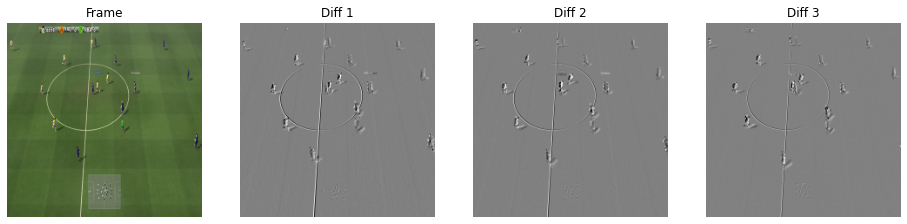

In [ ]:
# Zobrazenie jednotlivých RGB snímok
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 riadok s 4 obrázkami
axes = axes.ravel()  # Získame zoznam axov pre každý obrázok

obs = np.squeeze(gfootball_obs)
#obs = np.transpose(obs, (2, 0, 1))

axes[0].imshow(obs[..., :3])
axes[0].set_title("Frame")
axes[0].axis('off')  # Skryjeme osi

axes[1].imshow(obs[..., 3], cmap='gray')
axes[1].set_title("Diff 1")
axes[1].axis('off')  # Skryjeme osi

axes[2].imshow(obs[..., 4], cmap='gray')
axes[2].set_title("Diff 2")
axes[2].axis('off')  # Skryjeme osi

axes[3].imshow(obs[..., 5], cmap='gray')
axes[3].set_title("Diff 3")
axes[3].axis('off')  # Skryjeme osi

plt.show()

In [ ]:
real_obs = np.load("../.scratch/frames_no_name_npy/frame_10.npy")
real_obs.shape

In [23]:
real_obs.shape

(1, 6, 224, 224)

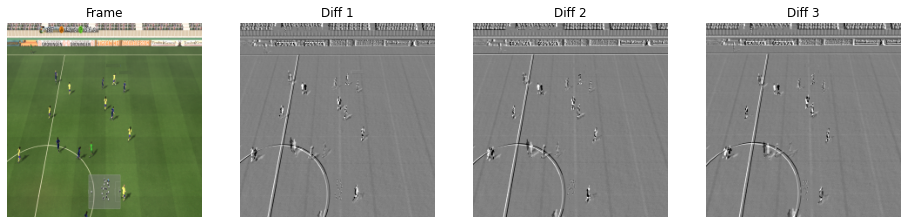

In [31]:
real_obs = np.load("../.scratch/frames_no_name_npy/frame_50.npy")

# Zobrazenie jednotlivých RGB snímok
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 riadok s 4 obrázkami
axes = axes.ravel()  # Získame zoznam axov pre každý obrázok

obs = np.squeeze(real_obs)
obs = np.transpose(obs, (1, 2, 0))

axes[0].imshow(obs[..., :3].astype(int))
axes[0].set_title("Frame")
axes[0].axis('off')  # Skryjeme osi

axes[1].imshow(obs[..., 3], cmap='gray')
axes[1].set_title("Diff 1")
axes[1].axis('off')  # Skryjeme osi

axes[2].imshow(obs[..., 4], cmap='gray')
axes[2].set_title("Diff 2")
axes[2].axis('off')  # Skryjeme osi

axes[3].imshow(obs[..., 5], cmap='gray')
axes[3].set_title("Diff 3")
axes[3].axis('off')  # Skryjeme osi

plt.show()

In [4]:
import numpy as np

# Načítanie dát zo súborov
gfootball_data = np.load('../.scratch/frames/episode_1/frame_0010.npy')  # Nahraď cestu k súboru s gfootball dátami
real_video_data = np.load('../chance_frame.npy')  # Nahraď cestu k súboru s reálnymi videami

# Zobrazenie tvaru dát
print(f"GFootball data shape: {gfootball_data.shape}")
print(f"Real video data shape: {real_video_data.shape}")


GFootball data shape: (224, 224, 6)
Real video data shape: (224, 224, 6)


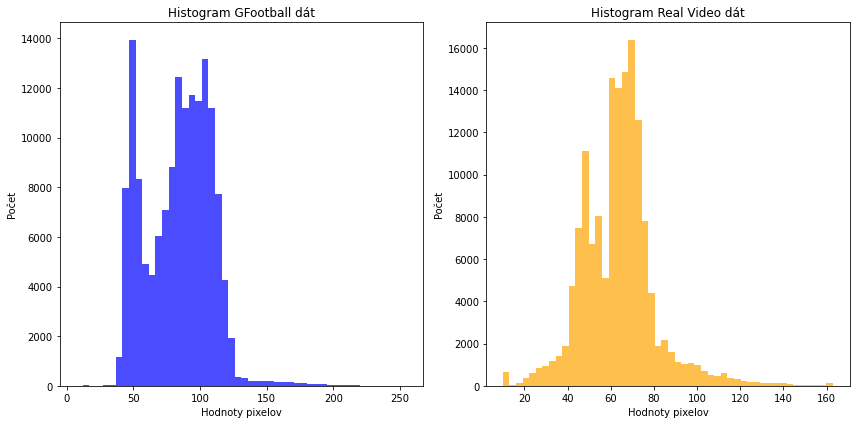

In [5]:
import matplotlib.pyplot as plt

# Predpokladáme, že gfootball_data a real_video_data sú 4D numpy polia (počet_obrázkov, výška, šírka, kanály)
# Ak máš 2D dáta (napr. len hodnoty), tento krok nebude aplikovateľný.

# Vytvorenie histograma pre GFootball dáta
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(gfootball_data[..., :3].flatten(), bins=50, color='blue', alpha=0.7, label="GFootball")
plt.title("Histogram GFootball dát")
plt.xlabel("Hodnoty pixelov")
plt.ylabel("Počet")

# Vytvorenie histograma pre reálne dáta
plt.subplot(1, 2, 2)
plt.hist(real_video_data[..., :3].flatten(), bins=50, color='orange', alpha=0.7, label="Real Videos")
plt.title("Histogram Real Video dát")
plt.xlabel("Hodnoty pixelov")
plt.ylabel("Počet")

# Zobrazenie grafu
plt.tight_layout()
plt.show()


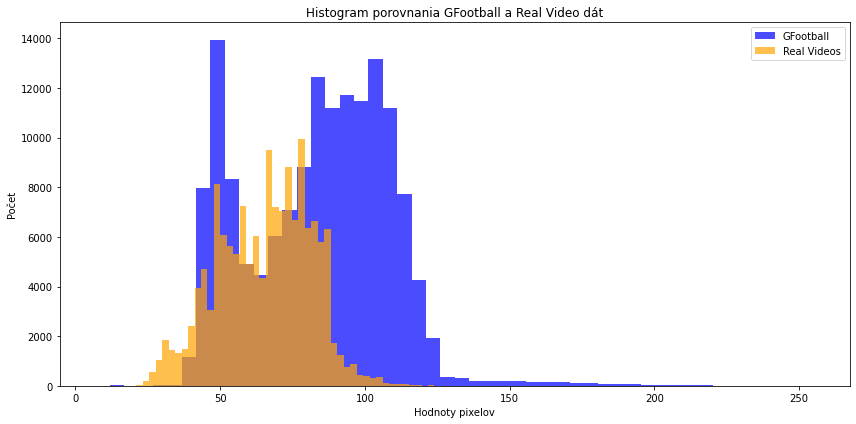

In [103]:
import matplotlib.pyplot as plt

# Predpokladáme, že gfootball_data a real_video_data sú 4D numpy polia (počet_obrázkov, výška, šírka, kanály)
# Ak máš 2D dáta (napr. len hodnoty), tento krok nebude aplikovateľný.

# Vytvorenie histograma pre GFootball dáta a Real Video dáta na jednom grafe
plt.figure(figsize=(12, 6))

# Histogram pre GFootball dáta
plt.hist(gfootball_data[..., :3].flatten(), bins=50, color='blue', alpha=0.7, label="GFootball")

# Histogram pre Real Video dáta
plt.hist(real_video_data[..., :3].flatten(), bins=50, color='orange', alpha=0.7, label="Real Videos")

# Titulky a popisky
plt.title("Histogram porovnania GFootball a Real Video dát")
plt.xlabel("Hodnoty pixelov")
plt.ylabel("Počet")
plt.legend()

# Zobrazenie grafu
plt.tight_layout()
plt.show()


In [ ]:
# Výpočet priemeru a smerodajnej odchýlky pre GFootball a reálne dáta
mean_gfootball = np.mean(gfootball_data)
std_gfootball = np.std(gfootball_data)

mean_real_video = np.mean(real_video_data)
std_real_video = np.std(real_video_data)

print(f"GFootball mean: {mean_gfootball}, std: {std_gfootball}")
print(f"Real video mean: {mean_real_video}, std: {std_real_video}")


GFootball mean: 105.66898185055273, std: 28.522805386525395
Real video mean: 93.60517883300781, std: 35.419376373291016


In [ ]:
from sklearn.metrics import mean_squared_error

# Predpokladajme, že máš obrázky v rovnakom formáte (napr. 3D numpy pole: [výška, šírka, kanály])
mse = mean_squared_error(gfootball_data.flatten(), real_video_data.flatten())
print(f"Mean Squared Error medzi gfootball a reálnymi dátami: {mse}")


Mean Squared Error medzi gfootball a reálnymi dátami: 603.054443359375


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Predpokladajme, že máme obrázky v jednom rozmere (napr. [batch_size, výška, šírka, kanály])
cos_sim = cosine_similarity(gfootball_data.reshape(-1, gfootball_data.shape[-1]), real_video_data.reshape(-1, real_video_data.shape[-1]))
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: [[0.96183686 0.96202129 0.9611342  ... 0.95443245 0.95436262 0.95259203]
 [0.96263494 0.96285918 0.96195432 ... 0.95531944 0.95528098 0.95350288]
 [0.96298445 0.96318173 0.96228653 ... 0.95567109 0.95560117 0.95383544]
 ...
 [0.98082132 0.98096475 0.98046698 ... 0.97547755 0.97540618 0.97424929]
 [0.97854675 0.97876189 0.97820232 ... 0.9737009  0.97372771 0.97252629]
 [0.98015172 0.98011908 0.97971335 ... 0.97479667 0.97459222 0.97352221]]


In [73]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import itertools

def simulate_style_transform(frame, sat=1.0, val=1.0, contrast=1.0, blur=0, noise_std=0.0):
    # HSV úprava (saturation, value)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 1] *= sat
    hsv[..., 2] *= val
    hsv = np.clip(hsv, 0, 255).astype(np.uint8)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR).astype(np.float32)

    # Kontrast
    bgr = cv2.convertScaleAbs(bgr, alpha=contrast, beta=0).astype(np.float32)

    # Blur
    if blur > 0:
        k = blur if blur % 2 == 1 else blur + 1  # kernel musí byť nepárny
        bgr = cv2.GaussianBlur(bgr, (k, k), 0)

    # Šum
    if noise_std > 0:
        noise = np.random.normal(0, noise_std * 255, bgr.shape)
        bgr += noise
        bgr = np.clip(bgr, 0, 255)

    return bgr.astype(np.uint8)

def compare_to_sim(real_frame, sim_frame, **params):
    aug = simulate_style_transform(real_frame, **params)
    gray_aug = cv2.cvtColor(aug, cv2.COLOR_BGR2GRAY)
    gray_sim = cv2.cvtColor(sim_frame, cv2.COLOR_BGR2GRAY)

    if gray_aug.shape != gray_sim.shape:
        gray_sim = cv2.resize(gray_sim, (gray_aug.shape[1], gray_aug.shape[0]))
    
    return ssim(gray_aug, gray_sim)

def find_best_augmentation(real_frame, sim_frame):
    sat_vals = [0.6, 0.7]
    val_vals = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
    contrast_vals = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
    blur_vals = [ 0, 1, 2, 3, 4, 5]          # 0 = žiadny blur
    noise_vals = [0.0, 0.01, 0.02] # std dev

    best_score = -1
    best_params = None

    combos = list(itertools.product(sat_vals, val_vals, contrast_vals, blur_vals, noise_vals))
    print(f"🔍 Testujem {len(combos)} kombinácií...")

    for sat, val, contrast, blur, noise in combos:
        params = {
            "sat": sat,
            "val": val,
            "contrast": contrast,
            "blur": blur,
            "noise_std": noise
        }
        score = compare_to_sim(real_frame, sim_frame, **params)
        print(f"sat={sat:.2f}, val={val:.2f}, contrast={contrast:.2f}, blur={blur}, noise={noise:.2f} -> SSIM={score:.4f}")
        if score > best_score:
            best_score = score
            best_params = params.copy()

    print("\n✅ Najlepšia kombinácia:")
    print(f"{best_params}, SSIM = {best_score:.4f}")
    return best_params, best_score


In [80]:
gfootball_data = np.load('../.scratch/frames/episode_1/frame_0010.npy') 
real_video_data = np.load('../chance_frame.npy') 

# Vyber len prvé tri kanály (ak sú v poradí BGR)
real_rgb = real_video_data[..., :3].astype(np.uint8)
sim_rgb = gfootball_data[..., :3].astype(np.uint8)

# Zavolaj funkciu na hľadanie najlepšej augmentácie
best_params, best_score = find_best_augmentation(real_rgb, sim_rgb)

🔍 Testujem 1764 kombinácií...
sat=0.60, val=0.60, contrast=0.60, blur=0, noise=0.00 -> SSIM=0.5446
sat=0.60, val=0.60, contrast=0.60, blur=0, noise=0.01 -> SSIM=0.5187
sat=0.60, val=0.60, contrast=0.60, blur=0, noise=0.02 -> SSIM=0.4640
sat=0.60, val=0.60, contrast=0.60, blur=1, noise=0.00 -> SSIM=0.5446
sat=0.60, val=0.60, contrast=0.60, blur=1, noise=0.01 -> SSIM=0.5192
sat=0.60, val=0.60, contrast=0.60, blur=1, noise=0.02 -> SSIM=0.4661
sat=0.60, val=0.60, contrast=0.60, blur=2, noise=0.00 -> SSIM=0.5652
sat=0.60, val=0.60, contrast=0.60, blur=2, noise=0.01 -> SSIM=0.5422
sat=0.60, val=0.60, contrast=0.60, blur=2, noise=0.02 -> SSIM=0.4853
sat=0.60, val=0.60, contrast=0.60, blur=3, noise=0.00 -> SSIM=0.5652
sat=0.60, val=0.60, contrast=0.60, blur=3, noise=0.01 -> SSIM=0.5419
sat=0.60, val=0.60, contrast=0.60, blur=3, noise=0.02 -> SSIM=0.4850
sat=0.60, val=0.60, contrast=0.60, blur=4, noise=0.00 -> SSIM=0.5748
sat=0.60, val=0.60, contrast=0.60, blur=4, noise=0.01 -> SSIM=0.5517
sat=